Epoch 1/2
69/69 ━━━━━━━━━━━━━━━━━━━━ 46s 599ms/step - accuracy: 0.8406 - loss: 0.8218 - val_accuracy: 0.8903 - val_loss: 0.5160 - learning_rate: 3.0000e-05
Epoch 2/2
69/69 ━━━━━━━━━━━━━━━━━━━━ 42s 615ms/step - accuracy: 0.8925 - loss: 0.4741 - val_accuracy: 0.9241 - val_loss: 0.3452 - learning_rate: 3.0000e-05
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 372ms/step - accuracy: 0.9189 - loss: 0.3534
Test Loss: 0.3558795750141144
Test Accuracy: 0.9168701171875


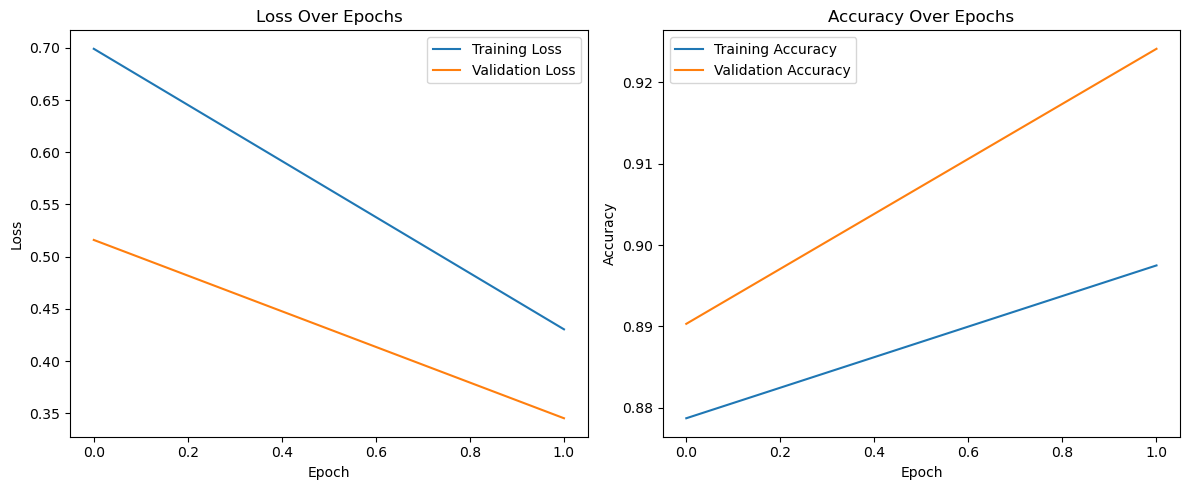

In [111]:
import numpy as np
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax, create_pairwise_gaussian, create_pairwise_bilateral

# 读取点云数据和标签
def load_labeled_point_cloud(file_path):
    data = []
    labels = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) == 4:
                x, y, z, label = map(float, parts)
                data.append([x, y, z])
                labels.append(int(label))
    return np.array(data), np.array(labels)

def create_voxel_grid(data, labels, grid_size):
    if data.size == 0 or labels.size == 0:
        print(f"Warning: Empty data or labels array. data.size={data.size}, labels.size={labels.size}")
        return None, None

    grid = np.zeros((grid_size, grid_size, grid_size))
    label_grid = np.zeros((grid_size, grid_size, grid_size))

    min_coords = np.min(data, axis=0)
    max_coords = np.max(data, axis=0)
    voxel_dim = (max_coords - min_coords) / grid_size

    for i, point in enumerate(data):
        voxel = ((point - min_coords) / voxel_dim).astype(int)
        voxel = np.clip(voxel, 0, grid_size-1)  # Ensure indices are within bounds
        grid[voxel[0], voxel[1], voxel[2]] = 1
        label_grid[voxel[0], voxel[1], voxel[2]] = labels[i] - 1  # Convert labels 1 and 2 to 0 and 1

    return grid, label_grid

def load_data_from_directory(data_dir, grid_size=32):
    x_data = []
    y_data = []
    for file in os.listdir(data_dir):
        if file.endswith("_labeled.txt"):
            file_path = os.path.join(data_dir, file)
            data, labels = load_labeled_point_cloud(file_path)
            if data.size == 0 or labels.size == 0:
                print(f"Skipping empty file: {file_path}")
                continue
            voxel_grid, label_grid = create_voxel_grid(data, labels, grid_size)
            if voxel_grid is not None and label_grid is not None:
                # 应用数据增强
                voxel_grid = augment_voxel_grid(voxel_grid)
                x_data.append(voxel_grid)
                y_data.append(label_grid)
    x_data = np.expand_dims(np.array(x_data), axis=-1)
    y_data = np.expand_dims(np.array(y_data), axis=-1)
    return x_data, y_data

# 数据增强
def augment_voxel_grid(voxel_grid):
    """
    对体素网格进行随机旋转和翻转。
    """
    # 随机旋转
    angle = np.random.uniform(0, 360)
    voxel_grid = np.rot90(voxel_grid, k=int(angle // 90), axes=(0, 1))
    
    # 随机翻转
    if np.random.rand() > 0.5:
        voxel_grid = np.flip(voxel_grid, axis=0)
    if np.random.rand() > 0.5:
        voxel_grid = np.flip(voxel_grid, axis=1)
    if np.random.rand() > 0.5:
        voxel_grid = np.flip(voxel_grid, axis=2)
    
    return voxel_grid

# 定义UNET模型
def unet_3d(input_shape):
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Encoder
    conv1 = tf.keras.layers.Conv3D(64, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(inputs)
    conv1 = tf.keras.layers.Conv3D(64, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(conv1)
    pool1 = tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2))(conv1)

    conv2 = tf.keras.layers.Conv3D(128, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(pool1)
    conv2 = tf.keras.layers.Conv3D(128, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(conv2)
    pool2 = tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2))(conv2)

    conv3 = tf.keras.layers.Conv3D(256, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(pool2)
    conv3 = tf.keras.layers.Conv3D(256, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(conv3)
    pool3 = tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2))(conv3)

    # Bottleneck
    conv4 = tf.keras.layers.Conv3D(512, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(pool3)
    conv4 = tf.keras.layers.Conv3D(512, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(conv4)

    # Decoder
    up5 = tf.keras.layers.Conv3DTranspose(256, 2, strides=(2, 2, 2), padding='same')(conv4)
    concat5 = tf.keras.layers.concatenate([up5, conv3], axis=-1)
    conv5 = tf.keras.layers.Conv3D(256, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(concat5)
    conv5 = tf.keras.layers.Conv3D(256, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(conv5)

    up6 = tf.keras.layers.Conv3DTranspose(128, 2, strides=(2, 2, 2), padding='same')(conv5)
    concat6 = tf.keras.layers.concatenate([up6, conv2], axis=-1)
    conv6 = tf.keras.layers.Conv3D(128, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(concat6)
    conv6 = tf.keras.layers.Conv3D(128, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(conv6)

    up7 = tf.keras.layers.Conv3DTranspose(64, 2, strides=(2, 2, 2), padding='same')(conv6)
    concat7 = tf.keras.layers.concatenate([up7, conv1], axis=-1)
    conv7 = tf.keras.layers.Conv3D(64, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(concat7)
    conv7 = tf.keras.layers.Conv3D(64, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(conv7)

    outputs = tf.keras.layers.Conv3D(2, 1, activation='softmax')(conv7)  # 2 channels output for binary classification

    model = tf.keras.models.Model(inputs=[inputs], outputs=[outputs])
    return model

# 定义学习率调度函数
def scheduler(epoch, lr):
    if epoch < 5:
        return float(lr)
    else:
        return float(lr * tf.math.exp(-0.1).numpy())

# 加载数据
data_dir = 'D:/BaiduSyncdisk/新建文件夹/桌面文件/深度学习程序/A-轮廓线识别/重新处理后的数据_手工筛选_0727/重新处理后的数据_手工筛选'
x_data, y_data = load_data_from_directory(data_dir, grid_size=16)

# 确保数据归一化
x_data = x_data / np.max(x_data)
y_data = y_data / np.max(y_data)

# 划分数据集
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.2, random_state=42
)

# 定义模型
input_shape = (16, 16, 16, 1)
model = unet_3d(input_shape)

# 编译模型
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00003), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# 定义学习率调度回调和早停回调
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 训练模型
history = model.fit(
    x_train, y_train, 
    validation_split=0.1,
    epochs=2, 
    batch_size=10,
    callbacks=[lr_scheduler, early_stopping]
)

# 评估模型
test_loss, test_accuracy = model.evaluate(x_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# 绘制训练过程中的损失和精确度
def plot_training_history(history):
    """
    绘制训练过程中的损失和精确度。
    """
    # 绘制损失
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    # 绘制精确度
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 绘制训练历史
plot_training_history(history)




In [113]:
def apply_crf(voxel_grid, probs):
    grid_size = voxel_grid.shape[0]
    num_voxels = grid_size * grid_size * grid_size

    print(f"Shape of voxel_grid: {voxel_grid.shape}")
    print(f"Shape of probs before stack: {probs.shape}")

    # 创建 DenseCRF 对象
    d = dcrf.DenseCRF(num_voxels, 2)

    # 创建 Unary 能量
    probs = np.stack([1 - probs, probs], axis=0)  # Create the correct shape for probabilities
    print(f"Shape of probs after stack: {probs.shape}")

    # Check if the array is C-contiguous, if not, make it contiguous
    if not probs.flags['C_CONTIGUOUS']:
        probs = np.ascontiguousarray(probs)
    
    probs = probs.reshape((2, num_voxels))  # Reshape probabilities to (2, num_voxels)
    print(f"Shape of probs after reshape: {probs.shape}")

    U = unary_from_softmax(probs)
    print(f"Shape of Unary Potentials: {U.shape}")
    d.setUnaryEnergy(U)

    # 增加高斯对势能（基于位置的光滑项）
    pairwise_gaussian = create_pairwise_gaussian(sdims=(3, 3, 3), shape=(grid_size, grid_size, grid_size))
    print("Pairwise Gaussian created")

    d.addPairwiseEnergy(pairwise_gaussian, compat=3)

    # 增加双边对势能（基于颜色和位置的光滑项）
    voxel_grid = voxel_grid.reshape((grid_size, grid_size, grid_size, 1))  # Reshape voxel grid to add a channel dimension
    print(f"Shape of voxel_grid after reshape: {voxel_grid.shape}")

    pairwise_bilateral = create_pairwise_bilateral(sdims=(3, 3, 3), schan=(1,), img=voxel_grid, chdim=3)
    print("Pairwise Bilateral created")
    d.addPairwiseEnergy(pairwise_bilateral, compat=10)

    # 进行推理
    Q = d.inference(5)
    Q = np.array(Q)  # 将 Q 转换为 NumPy 数组
    print(f"Q as array shape: {Q.shape}")
    print(f"Q contents: {Q}")

    # 获得分割结果
    result = np.argmax(Q, axis=0).reshape((grid_size, grid_size, grid_size))
    print(f"Shape of result: {result.shape}")

    return result


In [115]:
# 获取模型预测
y_pred_probs = model.predict(x_test)

# 打印形状信息进行调试
print("Shape of x_test:", x_test.shape)
print("Shape of y_pred_probs:", y_pred_probs.shape)

# 应用 CRF 后处理
y_pred_crf = []
for i in range(y_pred_probs.shape[0]):
    probs = y_pred_probs[i]
    print(f"Shape of probs: {probs.shape}")
    if probs.shape[-1] == 2:
        probs = probs[..., 1]  # Select the foreground probability
        print(f"Shape of probs after selecting foreground: {probs.shape}")
    else:
        raise ValueError(f"Unexpected shape for probs: {probs.shape}")
    y_pred_crf.append(apply_crf(x_test[i, ..., 0], probs))

y_pred_crf = np.array(y_pred_crf)

# 打印形状信息进行调试
print("Shape of y_pred_crf:", y_pred_crf.shape)
print("Shape of y_test:", y_test.shape)

# 评估 CRF 后处理后的结果
test_loss_crf, test_accuracy_crf = model.evaluate(y_pred_crf[..., np.newaxis], y_test)

print(f"Test Loss after CRF: {test_loss_crf}")
print(f"Test Accuracy after CRF: {test_accuracy_crf}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 322ms/step
Shape of x_test: (192, 16, 16, 16, 1)
Shape of y_pred_probs: (192, 16, 16, 16, 2)
Shape of probs: (16, 16, 16, 2)
Shape of probs after selecting foreground: (16, 16, 16)
Shape of voxel_grid: (16, 16, 16)
Shape of probs before stack: (16, 16, 16)
Shape of probs after stack: (2, 16, 16, 16)
Shape of probs after reshape: (2, 4096)
Shape of Unary Potentials: (2, 4096)
Pairwise Gaussian created
Shape of voxel_grid after reshape: (16, 16, 16, 1)
Pairwise Bilateral created
Q as array shape: (2, 4096)
Q contents: [[1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 9.9999964e-01
  9.9999988e-01 9.9999881e-01]
 [1.6188922e-09 1.1018680e-09 7.5988915e-10 ... 2.9861999e-07
  8.8893863e-08 1.1791059e-06]]
Shape of result: (16, 16, 16)
Shape of probs: (16, 16, 16, 2)
Shape of probs after selecting foreground: (16, 16, 16)
Shape of voxel_grid: (16, 16, 16)
Shape of probs before stack: (16, 16, 16)
Shape of probs after stack: (2, 16, 16, 16)
Shape of probs after resh

In [133]:
#保存模型

# 保存模型
model_save_path = 'D:/BaiduSyncdisk/新建文件夹/桌面文件/深度学习程序/模型-0725/unet_3d_model_CRF.h5'
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

# 加载模型
model_load_path = 'D:/BaiduSyncdisk/新建文件夹/桌面文件/深度学习程序/模型-0725/unet_3d_model_CRF.h5'
loaded_model = tf.keras.models.load_model(model_load_path)
print(f"Model loaded from {model_load_path}")


Model saved to D:/BaiduSyncdisk/新建文件夹/桌面文件/深度学习程序/模型-0725/unet_3d_model_CRF.h5
Model loaded from D:/BaiduSyncdisk/新建文件夹/桌面文件/深度学习程序/模型-0725/unet_3d_model_CRF.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
Shape of predictions: (1, 16, 16, 16, 2)
Shape of labels after argmax: (1, 16, 16, 16)
Shape of predicted_labels before CRF: (16, 16, 16)
Shape of voxel_grid: (16, 16, 16)
Shape of probs before stack: (16, 16, 16)
Shape of probs after stack: (2, 16, 16, 16)
Shape of probs after reshape: (2, 4096)
Shape of Unary Potentials: (2, 4096)
Pairwise Gaussian created
Shape of voxel_grid after reshape: (16, 16, 16, 1)
Pairwise Bilateral created
Q as array shape: (2, 4096)
Q contents: [[1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 1.0000000e+00]
 [1.8026287e-09 1.1967556e-09 8.0544305e-10 ... 3.3817669e-09
  3.2284619e-09 5.3977125e-09]]
Shape of result: (16, 16, 16)
Shape of predicted_labels_crf: (16, 16, 16)


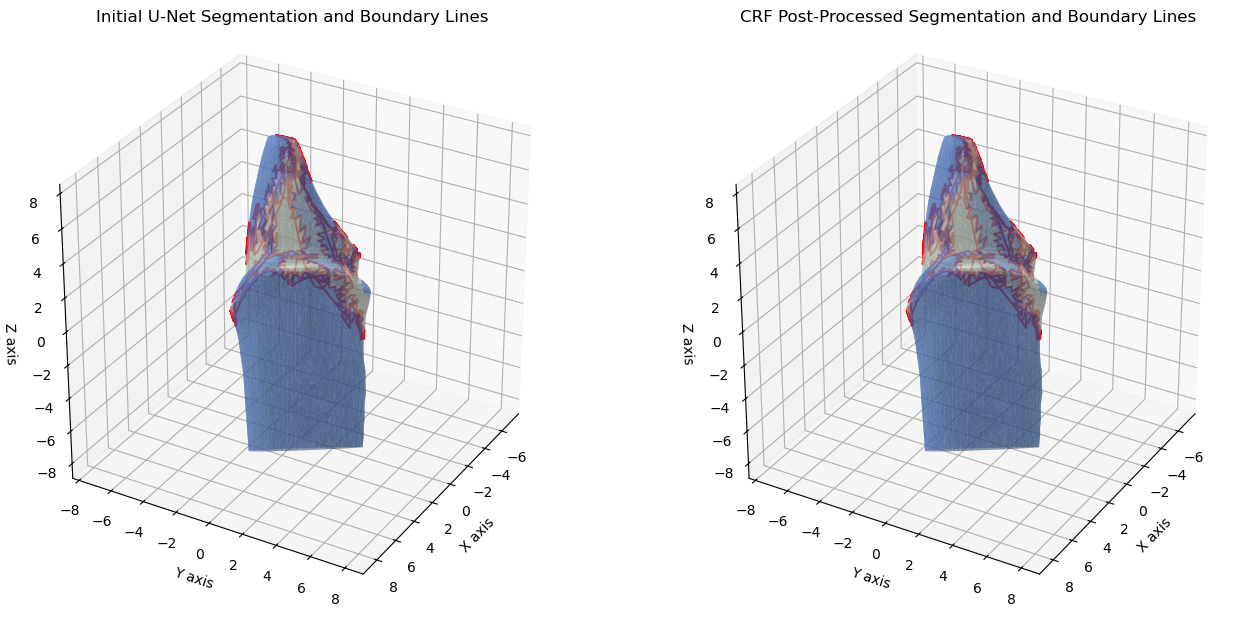

In [117]:
'''
模型用于预测，以及结果可视化
'''

# 开启交互旋转

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
from scipy.spatial import KDTree
from collections import defaultdict
from itertools import combinations

# 加载obj文件
def load_obj_file(file_path):
    vertices = []
    faces = []
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            for line in file:
                if line.startswith('v '):
                    parts = line.strip().split()
                    vertex = [float(parts[1]), float(parts[2]), float(parts[3])]
                    vertices.append(vertex)
                elif line.startswith('f '):
                    parts = line.strip().split()
                    face = [int(p.split('/')[0]) - 1 for p in parts[1:]]
                    faces.append(face)
    except FileNotFoundError:
        print(f"File not found: {file_path}")
    except Exception as e:
        print(f"An error occurred: {e}")
    return vertices, faces

# 将顶点平移至包围盒中心
def center_vertices(vertices):
    vertices_array = np.array(vertices)
    min_coords = vertices_array.min(axis=0)
    max_coords = vertices_array.max(axis=0)
    center = (min_coords + max_coords) / 2
    centered_vertices = vertices_array - center
    return centered_vertices.tolist()

# 点云转体素网格
def create_voxel_grid(data, grid_size):
    grid = np.zeros((grid_size, grid_size, grid_size))
    min_coords = np.min(data, axis=0)
    max_coords = np.max(data, axis=0)
    voxel_dim = (max_coords - min_coords) / grid_size

    for i, point in enumerate(data):
        voxel = ((point - min_coords) / voxel_dim).astype(int)
        voxel = np.clip(voxel, 0, grid_size-1)  # Ensure indices are within bounds
        grid[voxel[0], voxel[1], voxel[2]] = 1

    return grid, min_coords, voxel_dim

# 旋转点云
def rotate_points(points, angles):
    x_angle, y_angle, z_angle = angles
    Rx = np.array([
        [1, 0, 0],
        [0, np.cos(x_angle), -np.sin(x_angle)],
        [0, np.sin(x_angle), np.cos(x_angle)]
    ])
    Ry = np.array([
        [np.cos(y_angle), 0, np.sin(y_angle)],
        [0, 1, 0],
        [-np.sin(y_angle), 0, np.cos(y_angle)]
    ])
    Rz = np.array([
        [np.cos(z_angle), -np.sin(z_angle), 0],
        [np.sin(z_angle), np.cos(z_angle), 0],
        [0, 0, 1]
    ])
    R = Rz @ Ry @ Rx
    return points @ R.T

# 从训练好的模型获取标签
def get_labels_from_model(model, voxel_grid):
    voxel_grid = np.expand_dims(voxel_grid, axis=0)  # Add batch dimension
    voxel_grid = np.expand_dims(voxel_grid, axis=-1)  # Add channel dimension
    predictions = model.predict(voxel_grid)
    print(f"Shape of predictions: {predictions.shape}")
    labels = np.argmax(predictions, axis=-1)
    print(f"Shape of labels after argmax: {labels.shape}")
    return labels[0]

# 应用预测标签到原始点云
def apply_labels_to_point_cloud(data, predicted_labels, min_coords, voxel_dim, grid_size):
    labels = np.zeros(len(data))
    for i, point in enumerate(data):
        voxel = ((point - min_coords) / voxel_dim).astype(int)
        voxel = np.clip(voxel, 0, grid_size-1)  # Ensure indices are within bounds
        labels[i] = predicted_labels[voxel[0], voxel[1], voxel[2]]
    return labels

# 识别并合并分割线段
def find_boundary_edges(vertices, faces, labels):
    edges = defaultdict(list)
    for face in faces:
        for (v1, v2) in combinations(face, 2):
            if labels[v1] != labels[v2]:
                edges[tuple(sorted([v1, v2]))].append(face)
    
    # Create an adjacency list for edges
    adjacency_list = defaultdict(list)
    for (v1, v2), faces in edges.items():
        adjacency_list[v1].append(v2)
        adjacency_list[v2].append(v1)
    
    # Find all connected components of edges
    visited = set()
    boundary_lines = []
    for vertex in adjacency_list:
        if vertex not in visited:
            stack = [vertex]
            boundary_line = []
            while stack:
                current = stack.pop()
                if current not in visited:
                    visited.add(current)
                    boundary_line.append(current)
                    for neighbor in adjacency_list[current]:
                        if neighbor not in visited:
                            stack.append(neighbor)
            boundary_lines.append(boundary_line)
    
    # Calculate the length of each boundary line and sort by length
    boundary_lines = sorted(boundary_lines, key=lambda line: sum(np.linalg.norm(vertices[line[i]] - vertices[line[i + 1]]) for i in range(len(line) - 1)), reverse=True)
    return boundary_lines

# 绘制带有分类标签的点云和分界线
def plot_surface_with_marks(vertices, faces, labels, labels_crf, part1, part2, part1_crf, part2_crf, view_angles=(30, 30), angles=(0, 0, 0)):
    fig = plt.figure(figsize=(16, 8))

    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')

    vertices = np.array(vertices)
    faces = np.array(faces)

    # Apply rotation
    vertices = rotate_points(vertices, angles)
    
    x, y, z = vertices.T

    try:
        # 标记分割的点云部分 (初始U-Net分割)
        part1_faces = [face for face in faces if sum(labels[vertex] == 0 for vertex in face) > 1]
        part2_faces = [face for face in faces if sum(labels[vertex] == 1 for vertex in face) > 1]
        
        part1_faces = np.array(part1_faces)
        part2_faces = np.array(part2_faces)
        
        if len(part1_faces) > 0:
            ax1.plot_trisurf(vertices[:, 0], vertices[:, 1], vertices[:, 2], triangles=part1_faces, color='cornflowerblue', alpha=0.6)
        if len(part2_faces) > 0:
            ax1.plot_trisurf(vertices[:, 0], vertices[:, 1], vertices[:, 2], triangles=part2_faces, color='honeydew', alpha=0.6)

        # 找到边界线并绘制最长的边界线 (初始U-Net分割)
        boundary_lines = find_boundary_edges(vertices, faces, labels)
        if boundary_lines:
            longest_boundary_line = boundary_lines[0]
            ax1.plot(vertices[longest_boundary_line, 0], vertices[longest_boundary_line, 1], vertices[longest_boundary_line, 2], color='red')

        # 标记分割的点云部分 (CRF后处理)
        part1_faces_crf = [face for face in faces if sum(labels_crf[vertex] == 0 for vertex in face) > 1]
        part2_faces_crf = [face for face in faces if sum(labels_crf[vertex] == 1 for vertex in face) > 1]
        
        part1_faces_crf = np.array(part1_faces_crf)
        part2_faces_crf = np.array(part2_faces_crf)
        
        if len(part1_faces_crf) > 0:
            ax2.plot_trisurf(vertices[:, 0], vertices[:, 1], vertices[:, 2], triangles=part1_faces_crf, color='cornflowerblue', alpha=0.6)
        if len(part2_faces_crf) > 0:
            ax2.plot_trisurf(vertices[:, 0], vertices[:, 1], vertices[:, 2], triangles=part2_faces_crf, color='honeydew', alpha=0.6)

        # 找到边界线并绘制最长的边界线 (CRF后处理)
        boundary_lines_crf = find_boundary_edges(vertices, faces, labels_crf)
        if boundary_lines_crf:
            longest_boundary_line_crf = boundary_lines_crf[0]
            ax2.plot(vertices[longest_boundary_line_crf, 0], vertices[longest_boundary_line_crf, 1], vertices[longest_boundary_line_crf, 2], color='red')
            
    except ValueError as e:
        print(f"ValueError: {e}")
        return

    # 设置标签和标题
    ax1.set_xlabel('X axis')
    ax1.set_ylabel('Y axis')
    ax1.set_zlabel('Z axis')
    ax1.set_title('Initial U-Net Segmentation and Boundary Lines')
    
    ax2.set_xlabel('X axis')
    ax2.set_ylabel('Y axis')
    ax2.set_zlabel('Z axis')
    ax2.set_title('CRF Post-Processed Segmentation and Boundary Lines')

    # 确保坐标轴刻度一致
    max_range = np.array([max(x)-min(x), max(y)-min(y), max(z)-min(z)]).max()
    mid_x = (max(x) + min(x)) * 0.5
    mid_y = (max(y) + min(y)) * 0.5
    mid_z = (max(z) + min(z)) * 0.5
    ax1.set_xlim(mid_x - max_range/2, mid_x + max_range/2)
    ax1.set_ylim(mid_y - max_range/2, mid_y + max_range/2)
    ax1.set_zlim(mid_z - max_range/2, mid_z + max_range/2)

    ax2.set_xlim(mid_x - max_range/2, mid_x + max_range/2)
    ax2.set_ylim(mid_y - max_range/2, mid_y + max_range/2)
    ax2.set_zlim(mid_z - max_range/2, mid_z + max_range/2)

    # 设置视角
    elev, azim = view_angles
    ax1.view_init(elev=elev, azim=azim)
    ax2.view_init(elev=elev, azim=azim)

    # 确保坐标轴比例相等
    ax1.set_box_aspect([1,1,1])  # Aspect ratio is 1:1:1
    ax2.set_box_aspect([1,1,1])  # Aspect ratio is 1:1:1

    # 启用交互式旋转
    plt.show()

# 加载点云数据
obj_file_path = r'D:/BaiduSyncdisk/新建文件夹/桌面文件/深度学习程序/肩台外侧点_0715/叶老师.obj'
vertices, faces = load_obj_file(obj_file_path)
centered_vertices = center_vertices(vertices)

# 将点云转换为体素网格
grid_size = 16  # Ensure grid size matches model requirements
voxel_grid, min_coords, voxel_dim = create_voxel_grid(np.array(centered_vertices), grid_size)

# 使用训练好的模型进行预测
predicted_labels = get_labels_from_model(model, voxel_grid)

# 打印predicted_labels的形状
print(f"Shape of predicted_labels before CRF: {predicted_labels.shape}")

# 使用CRF后处理
predicted_labels_crf = apply_crf(voxel_grid, predicted_labels)

# 打印predicted_labels_crf的形状
print(f"Shape of predicted_labels_crf: {predicted_labels_crf.shape}")

# 获取原始点云的预测标签 (初始U-Net分割)
predicted_point_labels = apply_labels_to_point_cloud(np.array(centered_vertices), predicted_labels, min_coords, voxel_dim, grid_size)

# 获取原始点云的预测标签 (CRF后处理)
predicted_point_labels_crf = apply_labels_to_point_cloud(np.array(centered_vertices), predicted_labels_crf, min_coords, voxel_dim, grid_size)

# 定义分割的部分（需要根据实际情况定义）
part1 = {i for i, label in enumerate(predicted_point_labels) if label == 0}
part2 = {i for i, label in enumerate(predicted_point_labels) if label == 1}

part1_crf = {i for i, label in enumerate(predicted_point_labels_crf) if label == 0}
part2_crf = {i for i, label in enumerate(predicted_point_labels_crf) if label == 1}

# 画图
plot_surface_with_marks(centered_vertices, faces, predicted_point_labels, predicted_point_labels_crf, part1, part2, part1_crf, part2_crf, view_angles=(30, 30), angles=(np.radians(90), np.radians(-30), np.radians(30)))


Shape of voxel_grid: (16, 16, 16)
Shape of probs before stack: (16, 16, 16)
Shape of probs after stack: (2, 16, 16, 16)
Shape of probs after reshape: (2, 4096)
Shape of Unary Potentials: (2, 4096)
Pairwise Gaussian created
Shape of voxel_grid after reshape: (16, 16, 16, 1)
Pairwise Bilateral created
Q as array shape: (2, 4096)
Shape of result: (16, 16, 16)
Shape of predicted_labels_crf: (16, 16, 16)


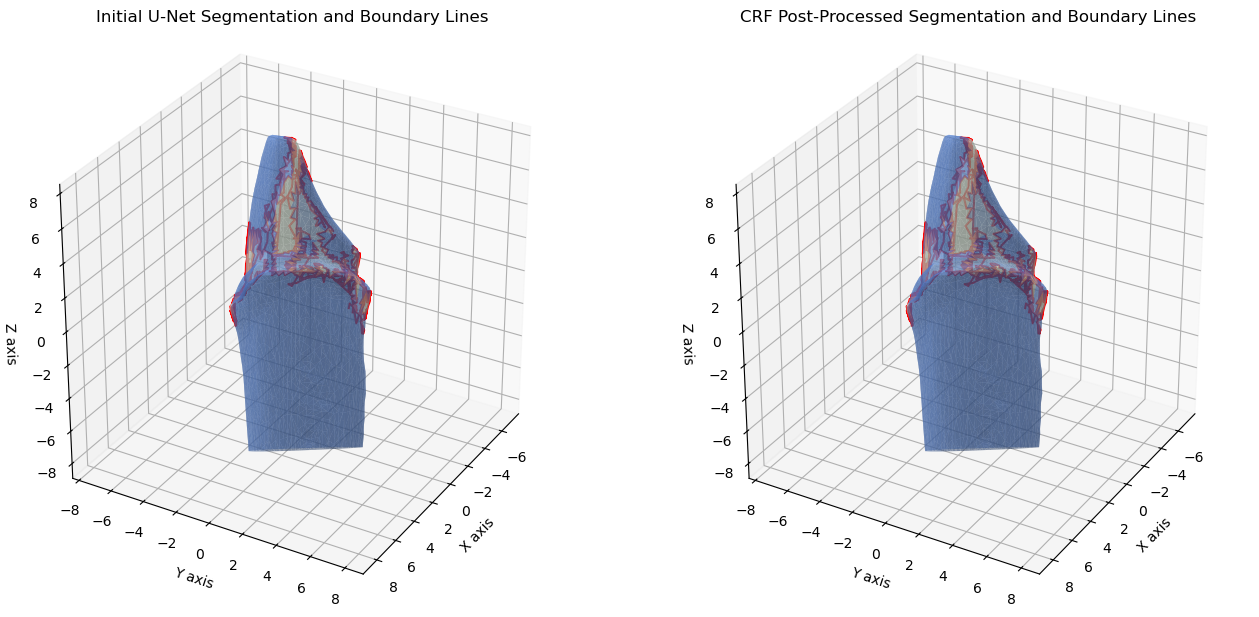

In [109]:
# 使用CRF后处理
predicted_labels_crf = apply_crf(voxel_grid, predicted_labels)

# 打印predicted_labels_crf的形状
print(f"Shape of predicted_labels_crf: {predicted_labels_crf.shape}")

# 获取原始点云的预测标签 (初始U-Net分割)
predicted_point_labels = apply_labels_to_point_cloud(np.array(centered_vertices), predicted_labels, min_coords, voxel_dim, grid_size)

# 获取原始点云的预测标签 (CRF后处理)
predicted_point_labels_crf = apply_labels_to_point_cloud(np.array(centered_vertices), predicted_labels_crf, min_coords, voxel_dim, grid_size)

# 定义分割的部分（需要根据实际情况定义）
part1 = {i for i, label in enumerate(predicted_point_labels) if label == 0}
part2 = {i for i, label in enumerate(predicted_point_labels) if label == 1}

part1_crf = {i for i, label in enumerate(predicted_point_labels_crf) if label == 0}
part2_crf = {i for i, label in enumerate(predicted_point_labels_crf) if label == 1}

# 画图
plot_surface_with_marks(centered_vertices, faces, predicted_point_labels, predicted_point_labels_crf, part1, part2, part1_crf, part2_crf, view_angles=(30, 30), angles=(np.radians(90), np.radians(-30), np.radians(30)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
Shape of predictions: (1, 16, 16, 16, 2)
Shape of labels after argmax: (1, 16, 16, 16)
Shape of voxel_grid: (16, 16, 16)
Shape of probs before stack: (16, 16, 16)
Shape of probs after stack: (2, 16, 16, 16)
Shape of probs after reshape: (2, 4096)
Shape of Unary Potentials: (2, 4096)
Pairwise Gaussian created
Shape of voxel_grid after reshape: (16, 16, 16, 1)
Pairwise Bilateral created
Q as array shape: (2, 4096)
Shape of result: (16, 16, 16)


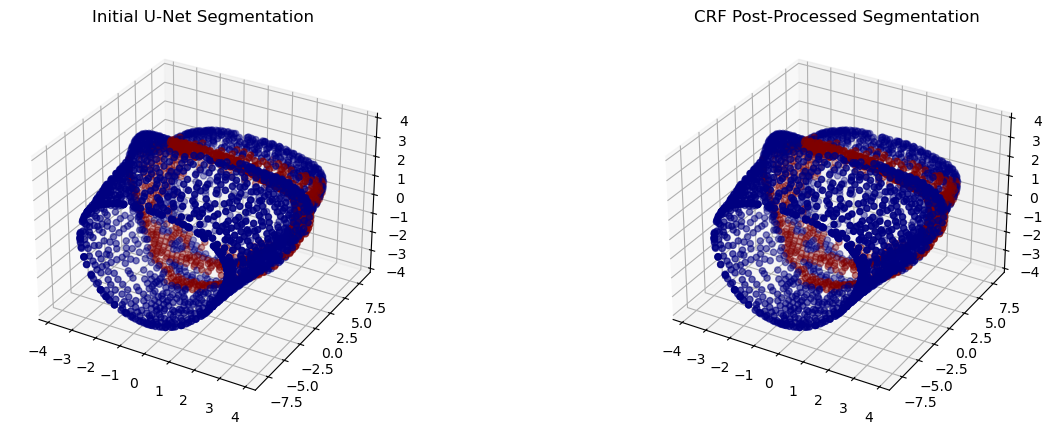

In [135]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax, create_pairwise_gaussian, create_pairwise_bilateral
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d.art3d as art3d

# 定义读取OBJ文件的函数
def load_obj_file(file_path):
    vertices = []
    faces = []
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            for line in file:
                if line.startswith('v '):
                    parts = line.strip().split()
                    vertex = [float(parts[1]), float(parts[2]), float(parts[3])]
                    vertices.append(vertex)
                elif line.startswith('f '):
                    parts = line.strip().split()
                    face = [int(p.split('/')[0]) - 1 for p in parts[1:]]
                    faces.append(face)
    except FileNotFoundError:
        print(f"File not found: {file_path}")
    except Exception as e:
        print(f"An error occurred: {e}")
    return np.array(vertices), np.array(faces)

# 将顶点平移至包围盒中心
def center_vertices(vertices):
    vertices_array = np.array(vertices)
    min_coords = vertices_array.min(axis=0)
    max_coords = vertices_array.max(axis=0)
    center = (min_coords + max_coords) / 2
    centered_vertices = vertices_array - center
    return centered_vertices

# 点云转体素网格
def create_voxel_grid(data, grid_size):
    grid = np.zeros((grid_size, grid_size, grid_size))
    min_coords = np.min(data, axis=0)
    max_coords = np.max(data, axis=0)
    voxel_dim = (max_coords - min_coords) / grid_size

    for point in data:
        voxel = ((point - min_coords) / voxel_dim).astype(int)
        voxel = np.clip(voxel, 0, grid_size-1)  # Ensure indices are within bounds
        grid[voxel[0], voxel[1], voxel[2]] = 1

    return grid, min_coords, voxel_dim

# 应用CRF后处理
def apply_crf(voxel_grid, probs):
    grid_size = voxel_grid.shape[0]
    num_voxels = grid_size * grid_size * grid_size

    print(f"Shape of voxel_grid: {voxel_grid.shape}")
    print(f"Shape of probs before stack: {probs.shape}")

    # 创建 DenseCRF 对象
    d = dcrf.DenseCRF(num_voxels, 2)

    # 创建 Unary 能量
    probs = np.stack([1 - probs, probs], axis=0)  # Create the correct shape for probabilities
    print(f"Shape of probs after stack: {probs.shape}")

    if not probs.flags['C_CONTIGUOUS']:
        probs = np.ascontiguousarray(probs)
    
    probs = probs.reshape((2, num_voxels))  # Reshape probabilities to (2, num_voxels)
    print(f"Shape of probs after reshape: {probs.shape}")

    U = unary_from_softmax(probs)
    print(f"Shape of Unary Potentials: {U.shape}")
    d.setUnaryEnergy(U)

    # 增加高斯对势能（基于位置的光滑项）
    pairwise_gaussian = create_pairwise_gaussian(sdims=(3, 3, 3), shape=(grid_size, grid_size, grid_size))
    print("Pairwise Gaussian created")
    d.addPairwiseEnergy(pairwise_gaussian, compat=3)

    # 增加双边对势能（基于颜色和位置的光滑项）
    voxel_grid = voxel_grid.reshape((grid_size, grid_size, grid_size, 1))  # Reshape voxel grid to add a channel dimension
    print(f"Shape of voxel_grid after reshape: {voxel_grid.shape}")

    pairwise_bilateral = create_pairwise_bilateral(sdims=(3, 3, 3), schan=(1,), img=voxel_grid, chdim=3)
    print("Pairwise Bilateral created")
    d.addPairwiseEnergy(pairwise_bilateral, compat=10)

    # 进行推理
    Q = d.inference(5)
    Q = np.array(Q)  # 将 Q 转换为 NumPy 数组
    print(f"Q as array shape: {Q.shape}")

    # 获得分割结果
    result = np.argmax(Q, axis=0).reshape((grid_size, grid_size, grid_size))
    print(f"Shape of result: {result.shape}")

    return result

# 从模型获取标签
def get_labels_from_model(model, voxel_grid):
    voxel_grid = np.expand_dims(voxel_grid, axis=0)  # Add batch dimension
    voxel_grid = np.expand_dims(voxel_grid, axis=-1)  # Add channel dimension
    predictions = model.predict(voxel_grid)
    print(f"Shape of predictions: {predictions.shape}")
    labels = np.argmax(predictions, axis=-1)
    print(f"Shape of labels after argmax: {labels.shape}")
    return labels[0]

# 应用预测标签到原始点云
def apply_labels_to_point_cloud(data, predicted_labels, min_coords, voxel_dim, grid_size):
    labels = np.zeros(len(data))
    for i, point in enumerate(data):
        voxel = ((point - min_coords) / voxel_dim).astype(int)
        voxel = np.clip(voxel, 0, grid_size-1)  # Ensure indices are within bounds
        labels[i] = predicted_labels[voxel[0], voxel[1], voxel[2]]
    return labels

# 定义可视化函数
def visualize_segmented_model(vertices, faces, labels, labels_crf):
    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')

    # 中心化顶点
    centered_vertices = center_vertices(vertices)

    x, y, z = centered_vertices.T

    # 初始分割结果
    ax1.scatter(x, y, z, c=labels, cmap='jet', marker='o')
    ax1.set_title('Initial U-Net Segmentation')

    # CRF 后处理结果
    ax2.scatter(x, y, z, c=labels_crf, cmap='jet', marker='o')
    ax2.set_title('CRF Post-Processed Segmentation')

    plt.show()

# 文件路径和模型路径
obj_file_path = r'D:/BaiduSyncdisk/新建文件夹/桌面文件/深度学习程序/肩台外侧点_0715/叶老师.obj'
model_path = 'D:/BaiduSyncdisk/新建文件夹/桌面文件/深度学习程序/模型-0725/unet_3d_model_CRF.h5'

# 加载OBJ文件
vertices, faces = load_obj_file(obj_file_path)
centered_vertices = center_vertices(vertices)

# 将点云转换为体素网格
grid_size = 16  # Ensure grid size matches model requirements
voxel_grid, min_coords, voxel_dim = create_voxel_grid(centered_vertices, grid_size)

# 加载模型
model = tf.keras.models.load_model(model_path)

# 使用训练好的模型进行预测
predicted_labels = get_labels_from_model(model, voxel_grid)

# 使用CRF后处理
predicted_labels_crf = apply_crf(voxel_grid, predicted_labels)

# 获取原始点云的预测标签 (初始U-Net分割)
predicted_point_labels = apply_labels_to_point_cloud(centered_vertices, predicted_labels, min_coords, voxel_dim, grid_size)

# 获取原始点云的预测标签 (CRF后处理)
predicted_point_labels_crf = apply_labels_to_point_cloud(centered_vertices, predicted_labels_crf, min_coords, voxel_dim, grid_size)

# 可视化分割结果
visualize_segmented_model(centered_vertices, faces, predicted_point_labels, predicted_point_labels_crf)
